## First things first
* Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.
* Click **Runtime -> Change runtime type** and select **GPU** or **TPU** in Hardware accelerator box to enable faster training.

##**Final Project for Coursera's 'How to Win a Data Science Competition'**
April, 2020;  Andreas Theodoulou and Michael Gaidis;  (Competition Info last updated:  3 years ago)

###**About this Competition**

You are provided with daily historical sales data. The task is to forecast the total amount of products sold in every shop for the test set. Note that the list of shops and products slightly changes every month. Creating a robust model that can handle such situations is part of the challenge.

Evaluation: root mean squared error (RMSE). True target values are clipped into [0,20] range.

.

###**File descriptions**

***sales_train.csv*** - the training set. Daily historical data from January 2013 to October 2015.

***test.csv*** - the test set. You need to forecast the sales for these shops and products for November 2015.

***sample_submission.csv*** - a sample submission file in the correct format.

***items.csv*** - supplemental information about the items/products.

***item_categories.csv***  - supplemental information about the items categories.

***shops.csv***- supplemental information about the shops.

.

###**Data fields**

***ID*** - an Id that represents a (Shop, Item) tuple within the test set

***shop_id*** - unique identifier of a shop

***item_id*** - unique identifier of a product

***item_category_id*** - unique identifier of item category

***item_cnt_day*** - number of products sold. You are predicting a monthly amount of this measure

***item_price*** - current price of an item

***date*** - date in format dd/mm/yyyy

***month*** - a consecutive month number. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

***item_name*** - name of item

***shop_name*** - name of shop

***item_category_name*** - name of item category

##**Import Modules, Set Up Environment**

In [2]:
from google.colab import drive  

# General python libraries/modules used throughout the notebook
from   itertools import product
from   collections import OrderedDict
import re
import os
from   pathlib import Path
import gc

# Helpful packages for EDA, cleaning, data manipulation
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ML packages
import lightgbm as lgb
from   lightgbm import LGBMRegressor
import sklearn
from   sklearn.preprocessing import MinMaxScaler, RobustScaler
from   sklearn.experimental import enable_hist_gradient_boosting  # noqa # explicitly require this experimental feature before importing HistGradientBoostingRegressor
from   sklearn.ensemble import HistGradientBoostingRegressor

# Pandas additional enhancements / formatting
pd.set_option('compute.use_bottleneck', False)  # speed up operation when using NaNs
pd.set_option('compute.use_numexpr', False)     # speed up boolean operations, large dataframes; DataFrame.query() and pandas.eval() will evaluate the subexpressions that can be evaluated by numexpr
pd.set_option("display.max_rows",60)            # Override pandas choice of how many rows to show, so we can see the full 84-row item_category df instead of '...' in the middle
pd.set_option("display.max_columns",30)         # Similar to row code above, we can show more columns than default
pd.set_option("display.width", 220)             # Tune this to our monitor window size to avoid horiz scroll bars in output windows (but, will get output text wrapping)
pd.set_option("max_colwidth", None)             # This is done, for example, so we can see full item name and not '...' in the middle
pd.options.display.float_format = lambda x : '{:.0f}'.format(x) if round(x,0) == x else '{:,.3f}'.format(x)   # print without decimals if a number is an integer; use 3 decimals if a float

# timing
import time
from   time import strftime, tzset, perf_counter
import datetime
from   datetime import timedelta
os.environ['TZ'] = 'EST+05EDT,M4.1.0,M10.5.0'   # allows user to simply print a formatted version of the local date and time; helps keep track of what cells were run, and when
tzset()                                         # set the time zone

print(f'Done: {strftime("%a %X %x")}')

Done: Fri 12:31:23 07/17/20


##**Mount Google Drive for access to Google Drive local repo**

In [3]:
# click on the URL link presented to you by this command, get your authorization code from Google, then paste it into the input box and hit 'enter' to complete mounting of the drive

GDRIVE_REPO_PATH = "/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag"
drive.mount('/content/drive')

print(f'Done: {strftime("%a %X %x")}')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Done: Fri 12:31:45 07/17/20


##**Define Various 'Constants' that Determine Feature Creation, Model Params, etc.**

In [4]:
# # column names of the loaded dataframes:
# items_enc_cols = ['item_id', 'item_tested', 'item_cluster', 'item_category_id', 'item_cat_tested', 'item_group', 'item_category1', 'item_category2', 'item_category3', 'item_category4']
# shops_enc_cols = ['shop_id', 'shop_tested', 'shop_group', 'shop_type', 's_type_broad', 'shop_federal_district', 'fd_popdens', 'fd_gdp', 'shop_city']
# date_adj_cols =  ['month', 'year', 'season', 'MoY', 'days_in_M', 'weekday_weight', 'retail_sales', 'week_retail_weight']
# train_test_base_cols = ['day', 'week', 'qtr', 'season', 'month', 'price', 'sales', 'shop_id', 'item_id']
# test_cols =      ['ID', 'shop_id', 'item_id']

In [5]:
# Parameters Dictionary stores everything for dumping to file later
par = OrderedDict()
par["MODEL_NAME"] = 'LGBMv11_15ens'   # 'LGBMv10_11ens'  # Name of file model substring to save data submission to (= False if user to input it below)
par["MODEL_TYPE"] = 'LGBM'  # 'HGBR'

# Optional operations to delete irrelevant shops or item categories, and to scale sales by month length, etc.;  set to FALSE if no operation desired
par["SHOPS_TO_DELETE"] = [9,20] #[0,1,8,9,11,13,17,20,23,27,29,30,32,33,40,43,51,54] #[8, 9, 13, 20, 23, 32, 33, 40] # [9,20] #  # False # these are online shops, untested shops, and early-termination + online shops
par["ITEM_CATS_TO_DELETE"] = [8, 10, 32, 59, 80, 81, 82]  #[1,4,8,10,13,14,17,18,32,39,46,48,50,51,52,53,59,66,68,80,81,82] #  #[8, 80, 81, 82]  # False # hokey categories, untested categories, really hokey categories
par["SCALE_MONTH"] = 'week_retail_weight'  # False # scale sales by days in month, number of each weekday, and Russian recession retail sales index

# columns to keep for this round of modeling (dropping some of the less important features to save memory):
par["ITEMS_KEEP_LIST"] = ['item_id', 'item_group', 'item_cluster', 'item_category_id'] #] #, 'item_category4']
par["SHOPS_KEEP_LIST"] = ['shop_id','shop_group'] #,'shop_group'
par["DATE_SCALING_KEEP_LIST"] =  ['month', 'days_in_M', 'weekday_weight', 'retail_sales', 'week_retail_weight']
par["TRAIN_TEST_BASE_KEEP_LIST"] =   ['month', 'price', 'sales', 'shop_id', 'item_id']

# re-order columns for organized readability, for the (to be created) combined sales-train-test (stt) dataset
par["STT_COLUMN_ORDER"] = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster'] #,   'revenue','item_category4','shop_group'
par["INTEGER_FEATURES"] = [e for e in par["STT_COLUMN_ORDER"] if e not in {'sales','price','revenue'}]  
par["CATEGORICAL_FEATURES"] = [e for e in par["STT_COLUMN_ORDER"] if e not in {'month','sales','price','revenue'}]
par["PROVIDED_FEATURES"] = [e for e in par["STT_COLUMN_ORDER"] if e not in {'month','sales','price','revenue','shop_id','item_id'}]  # these are categorical features that need to be merged onto test data set

par["STATISTICS"] = OrderedDict()
par["STATISTICS"]["sales"] = ['sum', 'median', 'count']
par["STATISTICS"]["revenue"] = ['sum']  # revenue can handle fillna(0) cartesian product; price doesn't make sense with fillna(0), so don't use that at this time
#par["STATISTICS"]["price"] = ['median','std']

# aggregate statistics columns (initial computation shall be 'sales per month' prediction target for shop_id-item_id pair grouping)
par["STATS_FEATURES"] = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster']] + par["CATEGORICAL_FEATURES"]

par["LAGS"] = [1,2,3,4,5,6,7,8]  # month lags to include in model 
par["COLUMNS_TO_LAG"] = {}
for i in par["LAGS"]:
    par["COLUMNS_TO_LAG"][i] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum'] 
par["COLUMNS_TO_LAG"][1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 
                     'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 
                     'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 
                     'shop_id_sales_sum', 'shop_id_sales_count', 
                     'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 
                     'shop_group_revenue_sum', 
                     'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 
                     'item_group_sales_sum', 'item_group_revenue_sum', 
                     'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']

par["COLUMNS_TO_LAG"][2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 
                     'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 
                     'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 
                     'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 
                     'item_category_id_sales_sum', 'item_category_id_sales_count', 
                     'item_group_sales_sum', 
                     'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']

par["COLUMNS_TO_LAG"][3] = ['y_sales', 'shop_id_x_item_id_sales_count', 
                     'shop_id_x_item_category_id_sales_sum', 
                     'shop_id_sales_sum', 
                     'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 
                     'item_category_id_sales_sum', 'item_category_id_sales_count', 
                     'item_cluster_sales_sum', 'item_cluster_sales_count']

# keep at least the highest importance feature for each lag, but remove all others with < 20% importance (month 13-32 training)
par["COLUMNS_TO_LAG"][2] = [e for e in par["COLUMNS_TO_LAG"][2] if e not in {'item_group_sales_sum','shop_id_x_item_category_id_sales_sum','shop_id_x_item_cluster_sales_sum','shop_id_x_item_cluster_sales_count'}]
par["COLUMNS_TO_LAG"][3] = [e for e in par["COLUMNS_TO_LAG"][3] if e not in {'item_cluster_sales_sum','shop_id_x_item_category_id_sales_sum','shop_id_x_item_id_sales_count'}]
par["COLUMNS_TO_LAG"][4] = [e for e in par["COLUMNS_TO_LAG"][4] if e not in {'shop_id_x_item_category_id_sales_sum','y_sales','item_cluster_sales_sum'}]
par["COLUMNS_TO_LAG"][5] = [e for e in par["COLUMNS_TO_LAG"][5] if e not in {'item_cluster_sales_sum','item_id_sales_sum','shop_id_x_item_category_id_sales_sum'}]
par["COLUMNS_TO_LAG"][6] = [e for e in par["COLUMNS_TO_LAG"][6] if e not in {'item_id_sales_sum','item_cluster_sales_sum','shop_id_x_item_category_id_sales_sum'}]
par["COLUMNS_TO_LAG"][7] = [e for e in par["COLUMNS_TO_LAG"][7] if e not in {'y_sales','item_cluster_sales_sum','shop_id_x_item_category_id_sales_sum'}]
par["COLUMNS_TO_LAG"][8] = [e for e in par["COLUMNS_TO_LAG"][8] if e not in {'item_id_sales_sum','item_cluster_sales_sum','shop_id_x_item_category_id_sales_sum'}]

# LAGGED_STATS_FEATURES is SET of all aggregate statistics columns for all lags (allows us to shed the other stats, keeping memory requirements low)
par["LAGGED_STATS_FEATURES"] = par["COLUMNS_TO_LAG"][1]
for l in par["LAGS"][1:]:
    par["LAGGED_STATS_FEATURES"] = par["LAGGED_STATS_FEATURES"] + [x for x in par["COLUMNS_TO_LAG"][l] if x not in par["LAGGED_STATS_FEATURES"]]
par["MONTHLY_STT_COLUMNS"] = par["INTEGER_FEATURES"] + par["LAGGED_STATS_FEATURES"]

# Define various constants that drive the attributes of the various features
par["SALES_TRAIN_CLIP_H"] = 20            # this clips sales after doing monthly groupings (monthly_stt dataframe) will also clip item_cnt_month predictions to 20 after the model runs
par["SALES_TRAIN_CLIP_L"] = 0                   
par["SALES_PREDICT_CLIP_H"] = 20          # this clips the final result before submission to coursera
par["SALES_PREDICT_CLIP_L"] = 0    

par["USE_ROBUST_SCALER"] = True           # scale features to reduce influence of outliers
par["ROBUST_SCALER_QUANTILES"] = (20,80)
par["USE_MINMAX_SCALER"] = True           # scale features to use large range of np.int16
par["MINMAX_SCALER_RANGE"] = (0,32000)    # int16 = (0,32700); uint16 = (0,65500)  --> keep this range positive for best results with LGBM
par["FEATURE_DATA_TYPE"] = np.int16       # np.float32 #np.int16   np.uint16          # if fill n/a = 0, can adjust feature values to be integer values and save memory (not finding that int can store np.NAN)
par["USE_CARTPROD_FILL"] = True           # use cartesian fill, or not
par["CARTPROD_WITH_TEST_PAIRS"] = False     # include all shop-item pairings from test month as well as the in-month pairings
par["CARTPROD_FILLNA_WITH_0"] = True        # fill n/a cartesian additions with zeros (not good for price-based stats, however)
par["CARTPROD_FILL_MONTH_BEGIN"] = 13     # month number + max lag to start adding Cartesian product rows (i.e., maxlag=6mo and CARTPROD_FILL_MONTH_BEGIN=10 will cartesian fill from 4 to 33)
par["TRAIN_MONTH_START"] = [13]           # == 24 ==> less than a year of data, but avoids December 'outlier' of 2014
par["TRAIN_MONTH_END"] = [29]             # [29,32] #,30,32]
par["N_VAL_MONTHS"] = [False]             #1 # ; if false, val is all months after training, up to and including 33; otherwise val is this many months after train_month_end

# Define hyperparameters for modeling
par["LEARNING_RATE"] = [0.02]  # default = 0.1
par["MAX_ITERATIONS"] = [20] # default = 100
par["EARLY_STOPPING"] = [20]
par["REGULARIZATION"] = [0.4] # default = 1 for LGBM, 0 for HGBR (these models use inverse forms of regularization)
par["VERBOSITY"] = 1 # 0 is print no info for HGBR
par["SEED_VALUES"] = [42]

par["N_TRAIN_MODELS"] = (len(par["SEED_VALUES"])*len(par["N_VAL_MONTHS"])*len(par["TRAIN_MONTH_END"])*len(par["TRAIN_MONTH_START"])*
                         len(par["EARLY_STOPPING"])*len(par["MAX_ITERATIONS"])*len(par["REGULARIZATION"])*len(par["LEARNING_RATE"]) )


print(f'Done: {strftime("%a %X %x")}')

Done: Fri 12:31:45 07/17/20


#**Set Up Environment and Load Files**
Load competition data files, import python modules, and set up pandas environment options

###Name the files you wish to load

In [6]:
# List of the *data* files (path relative to GitHub branch), to be loaded into pandas DataFrames
data_files = [  "data_output/items_enc.csv",
                "data_output/shops_enc.csv",
                "data_output/date_adjustments.csv",
                "data_output/train_test_base.csv.gz",
                "readonly/final_project_data/test.csv.gz" ]

###Load the files into pandas dataframes, from Google Drive local repo

In [7]:
%cd "{GDRIVE_REPO_PATH}"
print("Loading Files from Google Drive repo into Colab...\n")
for path_name in data_files:
    filename = path_name.rsplit("/")[-1]
    data_frame_name = filename.split(".")[0]
    exec(data_frame_name + " = pd.read_csv(path_name)")
    print(f'Data Frame: {data_frame_name}; n_rows = {len(eval(data_frame_name))}, n_cols = ',end="")
    print(f'{len(eval(data_frame_name).columns)}') #\nData Types: {eval(data_frame_name).dtypes}\n')
    print(f'Column Names: {eval(data_frame_name).columns.to_list()}')
    print(eval(data_frame_name).head(2))
    print("\n")

print(f'Done: {strftime("%a %X %x")}')

/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag
Loading Files from Google Drive repo into Colab...

Data Frame: items_enc; n_rows = 22170, n_cols = 10
Column Names: ['item_id', 'item_tested', 'item_cluster', 'item_category_id', 'item_cat_tested', 'item_group', 'item_category1', 'item_category2', 'item_category3', 'item_category4']
   item_id  item_tested  item_cluster  item_category_id  item_cat_tested  item_group  item_category1  item_category2  item_category3  item_category4
0        0            0           100                40                1           6               8               3               7               3
1        1            0           105                76                1           6              11               6              10               5


Data Frame: shops_enc; n_rows = 60, n_cols = 9
Column Names: ['shop_id', 'shop_tested', 'shop_group', 'shop_type', 's_type_broad', 'shop_federal_district', 'fd_popdens', 'fd_gdp', 'shop_city'

#**Data Preparation, Including Feature Merging and Feature Generation**

###**Helper Functions**

In [8]:
# helper function to print out column datatypes and memory usage, using multiple columns so we don't have to scroll so much
def print_col_info(df,nrows=5):
    """
    instead of the usual single column (plus index) series printout of dtypes and memory use in a dataframe,
    this function combines dtypes and memory use so they use the same index,
    and then prints out multiple columns of length "nrows", where each column is like: "column_dtype \t column_memory_use(MB) \t column_name"
        df = dataframe of interest
            col_dtypes = pd.Series, type obj, index = column_name, values = dtype  (e.g., from the command "df.dtypes")
            col_mem = pd.Series, type int64, index = column_name, values = column memory use (bytes) (e.g., from the command "df.memory_usage(deep=True)")
        nrows = int, tells how many rows of (type/mem/name) to print before moving to a new printout column for the next triplet (type/mem/name)
                if nrows == 0, print all triplets in just one column, with no "wrapping"
    finishes with a printout of total df memory usage
    """
    col_mem = df.memory_usage(deep=True)
    col_mem = col_mem/1e6  #change to MB
    total_mem = col_mem.sum()

    col_dtypes = pd.Series([df.index.dtype], index = ['Index'])  # df.memory_usage includes Index, but df.dtypes does not include Index, so we have to add it
    col_dtypes = pd.concat([col_dtypes,df.dtypes], axis=0)

    col_info_df = pd.concat([col_dtypes, col_mem], axis=1).reset_index().rename(columns={'index':'Column Name', 0:'DType', 1:'MBytes'})


    if nrows == 0:
        print(col_info_df)
    else:
        col_info_df.MBytes = col_info_df.MBytes.apply(lambda x: str(f'{x:.1f}'))
        info_df_len = len(col_info_df)
        cnames = col_info_df.columns
        n_info_cols = len(cnames)
        between_cols = 6  # spaces separating the info-group columns (e.g., between "ColName Dtype Mem" and next column "ColName Dtype Mem")

        # adjust number of rows such that we don't have nasty column with just one or a few rows
        stragglers = info_df_len % nrows
        n_print_cols = info_df_len // nrows
        if (stragglers > nrows/2):
            n_print_cols += 1
        elif (stragglers > 0):
            nrows = info_df_len // n_print_cols
            if info_df_len % n_print_cols > 0:
                nrows += 1

        df_list = []
        for pc in range(n_print_cols):
            df_list.append(col_info_df.shift(periods = -nrows*pc))
        df_print = pd.concat(df_list, axis = 1)
        df_print = df_print.iloc[:nrows][:].fillna(" ")
        col_headers = df_print.columns
        n_df_cols = len(col_headers)
        
        # find max string length in each column
        columnLengths = np.vectorize(len)
        maxColumnLengths = columnLengths(df_print.values.astype(str)).max(axis=0)
        col_widths = np.add(maxColumnLengths,3)

        for r in range(nrows+1):
            if r==0:
                string_list = col_headers
            else:
                string_list = df_print.iloc[r-1][:]
            print_row = ''
            c_count = 0
            for c in range(n_df_cols):
                print_row = print_row + f'{str(string_list[c]):>{col_widths[c]}} '
                c_count += 1
                if c_count == n_info_cols:
                    c_count = 0
                    print_row += " " * between_cols  # extra space between columns of common data

            print(print_row)

    print(f'\nNumber of rows in DataFrame: {len(df):,d}')
    print(f'DataFrame total memory usage: {total_mem:.0f} MB')
    

def rm_df(df):
    """
    try to save memory by deleting unneeded dataframes
    input can be a single dataframe, or a list of dataframes
    """
    if type(df) is list:
        for i in df:
            try: del i
            except: pass
    else:
        try: del df
        except: pass
    gc.enable()
    gc.collect()
    return

print(f'Done: {strftime("%a %X %x")}')

Done: Fri 12:31:51 07/17/20


##**Initial data prep, formatting**

###**Clean up the data, drop undesirable columns, merge shops and items info into train/test dataframe**

In [9]:
# Remove columns with features that we don't use at this time

shops_purged = shops_enc[par["SHOPS_KEEP_LIST"]].copy(deep=True) #.rename(columns = SHOPS_COLUMN_RENAME)
items_purged = items_enc[par["ITEMS_KEEP_LIST"]].copy(deep=True) #.rename(columns = ITEMS_COLUMN_RENAME)
date_adj_purged = date_adjustments[par["DATE_SCALING_KEEP_LIST"]].copy(deep=True)
stt = train_test_base[par["TRAIN_TEST_BASE_KEEP_LIST"]].copy(deep=True)  # 'stt' will be the dataframe for (S)ales of (T)rain appended with (T)est

print(f'shops_purged dataframe length: {len(shops_purged)}\n{shops_purged.head(2)}\n')
print(f'items_purged dataframe length: {len(items_purged)}\n{items_purged.head(2)}\n')
print(f'date_adj_purged dataframe length: {len(date_adj_purged)}\n{date_adj_purged.head(2)}\n')
print(f'stt dataframe length: {len(stt)}\n{stt.head(2)}\n')

rm_df([shops_enc, items_enc, date_adjustments, train_test_base])

print(f'Done: {strftime("%a %X %x")}')

shops_purged dataframe length: 60
   shop_id  shop_group
0        0           7
1        1           7

items_purged dataframe length: 22170
   item_id  item_group  item_cluster  item_category_id
0        0           6           100                40
1        1           6           105                76

date_adj_purged dataframe length: 35
   month  days_in_M  weekday_weight  retail_sales  week_retail_weight
0      0         31           0.979         1.052               1.030
1      1         28           1.069         1.072               1.146

stt dataframe length: 3150043
   month  price  sales  shop_id  item_id
0      0     99      1        2      991
1      0   2599      1        2     1472

Done: Fri 12:31:51 07/17/20


In [10]:
print(f'Shape of stt before merging and deleting: {stt.shape}')
# Merge shops and items into stt
stt = stt.merge(shops_purged, on='shop_id', how='left')
stt = stt.merge(items_purged, on='item_id', how='left')
print(f'Shape of stt after merging shops and items data: {stt.shape}')

# drop undesirable shops and item categories
if par["SHOPS_TO_DELETE"]:
    x = par["SHOPS_TO_DELETE"];  stt = stt.query('shop_id != @x')
    print(f'Shape of stt after deleting shops {par["SHOPS_TO_DELETE"]}: {stt.shape}')

if par["ITEM_CATS_TO_DELETE"]:
    x = par["ITEM_CATS_TO_DELETE"];  stt = stt.query('item_category_id != @x')
    print(f'Shape of stt after deleting item categories {par["ITEM_CATS_TO_DELETE"]}: {stt.shape}')

stt[par["INTEGER_FEATURES"]] = stt[par["INTEGER_FEATURES"]].astype('int16')

# scale by date_adjustments as desired
if par["SCALE_MONTH"]:
    stt = stt.merge(date_adj_purged[['month',par["SCALE_MONTH"]]], on='month', how='left')
    stt.sales = stt.sales * stt[par["SCALE_MONTH"]]
    stt.drop(par["SCALE_MONTH"], axis=1, inplace=True) 

# Clip the values of item sales per day (will clip again after grouping by month, and then clip at 20 just before submission of results for grading)
# stt.sales = stt.sales.clip(par["SALES_TRAIN_CLIP_L"], par["SALES_TRAIN_CLIP_H"])

stt['revenue'] = stt.sales * stt.price / 1000

stt[['sales','price','revenue']].astype(np.float32) #apply(pd.to_numeric, downcast= 'np.float32') # use float so fractional date_adj weight is more accurate, and can use price feature #reset index saves 25MB

stt = stt[par["STT_COLUMN_ORDER"]]
stt = stt.reset_index(drop=True)

print('\nstt dataframe:'); print_col_info(stt,5); display(stt.head(2))
print(f'Done: {strftime("%a %X %x")}')

Shape of stt before merging and deleting: (3150043, 5)
Shape of stt after merging shops and items data: (3150043, 9)
Shape of stt after deleting shops [9, 20]: (3144500, 9)
Shape of stt after deleting item categories [8, 10, 32, 59, 80, 81, 82]: (3124617, 9)

stt dataframe:
Column Name      DType  MBytes               Column Name    DType MBytes       
     Index      int64     0.0                   item_id    int16    6.2       
     month      int16     6.2                shop_group    int16    6.2       
     sales    float64    25.0          item_category_id    int16    6.2       
   revenue    float64    25.0                item_group    int16    6.2       
   shop_id      int16     6.2              item_cluster    int16    6.2       

Number of rows in DataFrame: 3,124,617
DataFrame total memory usage: 94 MB


,month,sales,revenue,shop_id,item_id,shop_group,item_category_id,item_group,item_cluster
0,0,1.030,0.102,2,991,9,67,5,463
1,0,1.030,2.677,2,1472,9,23,7,585


Done: Fri 12:31:53 07/17/20


##**Compute and Merge Statistics-Based Features on Grouped-by-Month training data**

###Create monthly_stt dataframe, grouping by month the (s)ales_(t)rain_(t)est dataframe

In [11]:
# Compute values in "real time," then in a later code cell we will compute shifted versions

monthly_stt = pd.DataFrame()
def compute_stats(df=stt, monthly_df=monthly_stt, no_merge=True, group=['month','item_id'], 
                  aggstats={'sales':['sum','median']}, aggcolnames=['item_id_sales_sum','item_id_sales_med']):
    """
    function for computing statistics-based features, in an attempt to be flexible if
    we wish to add in extra statistics or extra group-by categories
    no_merge True during first runthrough of this function, to create the initial dataframe into which we will merge various statistics features
    """
    group_df = df.groupby(group).agg(aggstats)
    group_df.columns = aggcolnames
    group_df.reset_index(inplace=True)
    if no_merge:  # this creates the initial monthly-grouped dataframe into which we will merge all other grouped statistics
        monthly_df = group_df.copy(deep=True)
    else:
        monthly_df = monthly_df.merge(group_df, on = group, how = 'left')
    return monthly_df           # original monthly_df merged with aggregated and suitably named stats columns created from ungrouped dataframe (stt)

stats = OrderedDict()
stats_col_names = []
for i,feat in enumerate(par["STATS_FEATURES"]):
    if type(feat) is list:
        f = "_x_".join(feat)
        gp = ['month'] + feat
    else:
        f = feat
        gp = ['month'] + [feat]
    agg_stats = OrderedDict()
    agg_names = []
    if i == 0:
        for pf in par["PROVIDED_FEATURES"]:
            agg_stats[pf] = ['first']
            agg_names.append(pf)
    for k,v in par["STATISTICS"].items():
        agg_stats[k] = v
        for val in v:
            agg_names.append(f + "_" + k + "_" + val)
            stats_col_names.append(f + "_" + k + "_" + val)
    stats[f] = {'group':gp, 'aggstats':agg_stats, 'aggnames':agg_names}

no_merge = True
print('Completed: ',end='')
for k,v in stats.items():
    monthly_stt = compute_stats(stt, monthly_stt, no_merge, v['group'], v['aggstats'], v['aggnames']).copy(deep=True)
    no_merge = False
    print(f'{k}, ',end='')
print('\nDone')

monthly_stt = monthly_stt.rename(columns={'shop_id_x_item_id_sales_sum':'y_sales'})  # rename for convenience
stats_col_names = ['y_sales'] + stats_col_names[1:]
monthly_stt.y_sales = monthly_stt.y_sales.clip(par["SALES_TRAIN_CLIP_L"], par["SALES_TRAIN_CLIP_H"])
monthly_stt = monthly_stt[par["MONTHLY_STT_COLUMNS"]]   #  = par["INTEGER_FEATURES"] + par["LAGGED_STATS_FEATURES"]

# always do minmax scaling after robust scaling; and do inverse scaling with minmax first, then robust
if par["USE_ROBUST_SCALER"]:
    robust_scalers = {} # squeeze outliers into central distribution
    for aggcol in par["LAGGED_STATS_FEATURES"]:
        robust_scalers[aggcol] = RobustScaler(with_centering=False,quantile_range=par["ROBUST_SCALER_QUANTILES"])
        monthly_stt[aggcol] = robust_scalers[aggcol].fit_transform(monthly_stt[aggcol].to_numpy().reshape(-1, 1))
if par["USE_MINMAX_SCALER"]:
    minmax_scalers = {}  # apply min-max scaler to make best use of np.int16 and memory usage
    for aggcol in par["LAGGED_STATS_FEATURES"]:
        minmax_scalers[aggcol] = MinMaxScaler(feature_range=par["MINMAX_SCALER_RANGE"])
        if (par["FEATURE_DATA_TYPE"] == np.int16) or (par["FEATURE_DATA_TYPE"] == np.uint16):
            monthly_stt[aggcol] = monthly_stt[aggcol].fillna(0)
        monthly_stt[aggcol] = minmax_scalers[aggcol].fit_transform(monthly_stt[aggcol].to_numpy().reshape(-1, 1))

monthly_stt.sort_values(['month','shop_id','item_id'],inplace=True)

print(f'\nmonthly_stt fully grouped and merged: memory usage = {monthly_stt.memory_usage(deep=True).sum()/1e6:.0f} MBytes')

if (par["FEATURE_DATA_TYPE"] == np.int16) or (par["FEATURE_DATA_TYPE"] == np.uint16):
    monthly_stt = monthly_stt.round()
monthly_stt = monthly_stt.reset_index(drop=True).astype(par["FEATURE_DATA_TYPE"])

print('\nmonthly_stt (after reset_index) and downcast:')
print_col_info(monthly_stt,6)
print('\n')
print(monthly_stt.head())
print(monthly_stt.describe())
print(f'Done: {strftime("%a %X %x")}')

Completed: shop_id_x_item_id, shop_id_x_item_category_id, shop_id_x_item_cluster, shop_id, item_id, shop_group, item_category_id, item_group, item_cluster, 
Done

monthly_stt fully grouped and merged: memory usage = 435 MBytes

monthly_stt (after reset_index) and downcast:
        Column Name    DType MBytes                                      Column Name    DType MBytes                                     Column Name    DType MBytes                           Column Name    DType MBytes                                     Column Name    DType MBytes       
              Index    int64    0.0                                     item_cluster    int16    3.6          shop_id_x_item_category_id_sales_count    int16    3.6                   item_id_sales_count    int16    3.6                          item_group_revenue_sum    int16    3.6       
              month    int16    3.6                                          y_sales    int16    3.6                shop_id_x_item_cluster_sales_s

##**Add Cartesian Product rows to the training data:**
Idea is to help the model by informing it that we explicitly have no information about certain relevant shop_item pairs in certain months.

###*Use numpy to create Cartesian Product:*
Each month in train data will have additional rows such that the Cartesian Product of all shops and items ALREADY PRESENT IN THAT MONTH will be included.</br>

When we merge lagged features below, we will only forward-shift the shop-item pairs that are present in the later month.</br>
*(Might revisit later, if memory requirements not too big, can forward-shift all shop-item pairs.)*

#####*If not adding Cartesian Product, or if fillna(0), can round various features to integers to save memory:*

In [12]:
rm_df(stt)

tic = perf_counter()
maxlags = max(par["LAGS"])
if par["USE_CARTPROD_FILL"]:
    # Create cartesian product so model has info to look at for every relevant shop-item-month combination in the months desired
    # add enough months of cartesian product that after time-LAGS, we end up with CartProds in months CARTPROD_FILL_MONTH_BEGIN through 33 (don't need to fill month 34)
    matrix = []
    for i in range(max(par["CARTPROD_FILL_MONTH_BEGIN"]-maxlags,0),34):
        if par["CARTPROD_WITH_TEST_PAIRS"]:
            sales = monthly_stt.query('(month == @i)|(month == 34)')  # include all test shop-items in with cartesian product from that month
        else:
            sales = monthly_stt.query('month == @i')  # include only shop-items present in that month
        matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype=np.int16))    

    df = pd.DataFrame(np.vstack(matrix), columns=['month','shop_id','item_id'])

    # # merge in the rows from training set with month < CART_FILL_MO_START ? (and > maxlags )??
    # now merge in the rows for the test set, month 34
    df = df.append(monthly_stt[monthly_stt.month ==34][['month','shop_id','item_id']], ignore_index=True)
    df = df.reset_index(drop=True)
    print(f'Column Data Types: \n{df.dtypes}\ndf memory usage: {df.memory_usage(deep=True).sum()/1e6:.0f} MBytes')
    print(f'Number of months: {df.month.nunique():,d}\nNumber of shops: {df.shop_id.nunique():,d}\nNumber of items: {df.item_id.nunique():,d}\nDataFrame length: {len(df):,d}\n')

    # merge the shops_purged dataframe: (can't just merge with monthly_stt, because cartesian product df has more shop-item pairs)
    df = df.merge(shops_purged, how='left', on='shop_id')
    # Next, merge the items_purged dataframe to be sure we cover all items in the cartesian product df
    df = df.merge(items_purged, how='left', on='item_id')

    df.sort_values(['month','shop_id','item_id'],inplace=True)
    df = df.reset_index(drop=True)
    # Now we merge in the real-time block-month data and see if memory requirements aren't overloading Colab:
    if par["CARTPROD_FILLNA_WITH_0"] or (par["FEATURE_DATA_TYPE"] == np.int16) or (par["FEATURE_DATA_TYPE"] == np.uint16):
        df = df.merge(monthly_stt, how='left',on=par["INTEGER_FEATURES"]).fillna(0).reset_index(drop=True) # can store as integers, saving memory, but issue with price fill values... need to kill price stats / use revenue
    else:
        df = df.merge(monthly_stt, how='left',on=par["INTEGER_FEATURES"]).reset_index(drop=True)   # leave cartesian product row unknowns as N/A (float, not integer)

    print('Cartesian-product df:')
else:
    df = monthly_stt.copy(deep=True)
    print('df with no Cartesian-products:')

toc = perf_counter()
print(f"df creation time: {timedelta(seconds = toc - tic)}")

rm_df(monthly_stt)

df = df.astype(par["FEATURE_DATA_TYPE"]) #np.int16 #.apply(pd.to_numeric, downcast= np.float32)
df=df.reset_index(drop=True)
print_col_info(df,6)
print(f'\ndf.head:\n{df.head(2)}')
print(f'\ndf.tail:\n{df.tail(2)}\n')
# display(df.describe())

print(f'\nDone: {strftime("%a %X %x")}')

Column Data Types: 
month      int16
shop_id    int16
item_id    int16
dtype: object
df memory usage: 55 MBytes
Number of months: 30
Number of shops: 53
Number of items: 20,106
DataFrame length: 9,124,719

Cartesian-product df:
df creation time: 0:00:20.522911
    Column Name    DType  MBytes                                      Column Name    DType  MBytes                                     Column Name    DType  MBytes                           Column Name    DType  MBytes                                     Column Name    DType  MBytes       
          Index    int64     0.0                                 item_category_id    int16    18.2          shop_id_x_item_category_id_sales_count    int16    18.2                   item_id_sales_count    int16    18.2                          item_group_revenue_sum    int16    18.2       
          month    int16    18.2                                          y_sales    int16    18.2                shop_id_x_item_cluster_sales_sum    int16  

##**Compute and Merge the Time-Lag Features into Train + Test data sets**

###*Merge lag stats and check dataframe memory requirements:*

In [13]:
%%time
# shift the stuff and merge into df
#   drop any rows in t-lag that don't have matching shop-item pair at time t
print(f'Unlagged DataFrame length: {len(df):,d}\n')
df['y_target'] = df.y_sales.copy(deep=True)  # keep an unlagged version of shop_item sales per month as our training / test target value
lag_merge_on_cols = ['month','shop_id','item_id']
cols_to_shift = lag_merge_on_cols + par["LAGGED_STATS_FEATURES"]
lag_cols_df = df[cols_to_shift].copy(deep=True)  
df.drop(par["LAGGED_STATS_FEATURES"], axis=1, inplace=True)  # reduce size of df in memory so merging below doesn't crash Colab
for lag in par["LAGS"]:
    cols_to_shift = lag_merge_on_cols + par["COLUMNS_TO_LAG"][lag]
    lag_df = lag_cols_df[cols_to_shift].copy(deep=True)  
    lag_df.eval('month = month + @lag', inplace=True)
    suffix = '_L'+str(lag)
    lagged_col_names = lag_merge_on_cols + [x + suffix for x in par["COLUMNS_TO_LAG"][lag]]
    lag_df.columns = lagged_col_names
    print(f'Column names for lag = {lag}: {lag_df.columns}')
    lag_df = lag_df.astype(par["FEATURE_DATA_TYPE"])
    if par["CARTPROD_FILLNA_WITH_0"] or (par["FEATURE_DATA_TYPE"] == np.int16) or (par["FEATURE_DATA_TYPE"] == np.uint16):
        df = df.merge(lag_df, on = lag_merge_on_cols, how = 'left').fillna(0)  # 'left' serves to discard rows from earlier month if there is no match with later month
        print('fillna(0) done\n')
    else:
        df = df.merge(lag_df, on = lag_merge_on_cols, how = 'left')
    df = df.reset_index(drop=True)
    df = df.astype(par["FEATURE_DATA_TYPE"])
print(df.head(2))
print(df.dtypes)

first_train_month = min(par["TRAIN_MONTH_START"])
print(f'Lagged DataFrame length: {len(df):,d}\n')
df = df.query('month >= @first_train_month')      # remove early months that don't participate in model training
df = df.reset_index(drop=True)
df = df.astype(par["FEATURE_DATA_TYPE"])  #.apply(pd.to_numeric, downcast= 'float')
print('lagged features df (after downcast):')
print_col_info(df,8)
print(f'\ndf.head():\n{df.head()}')

print(f'\nDone: {strftime("%a %X %x")}\n')

Unlagged DataFrame length: 9,124,719

Column names for lag = 1: Index(['month', 'shop_id', 'item_id', 'y_sales_L1', 'shop_id_x_item_id_sales_median_L1', 'shop_id_x_item_id_sales_count_L1', 'shop_id_x_item_id_revenue_sum_L1', 'shop_id_x_item_category_id_sales_sum_L1',
       'shop_id_x_item_category_id_sales_median_L1', 'shop_id_x_item_category_id_sales_count_L1', 'shop_id_x_item_cluster_sales_sum_L1', 'shop_id_x_item_cluster_sales_median_L1', 'shop_id_sales_sum_L1',
       'shop_id_sales_count_L1', 'item_id_sales_sum_L1', 'item_id_sales_median_L1', 'item_id_sales_count_L1', 'item_id_revenue_sum_L1', 'shop_group_revenue_sum_L1', 'item_category_id_sales_sum_L1',
       'item_category_id_sales_count_L1', 'item_category_id_revenue_sum_L1', 'item_group_sales_sum_L1', 'item_group_revenue_sum_L1', 'item_cluster_sales_sum_L1', 'item_cluster_sales_count_L1',
       'item_cluster_revenue_sum_L1'],
      dtype='object')
fillna(0) done

Column names for lag = 2: Index(['month', 'shop_id', 'item_id

#**Modeling**
*   Train/Val/Test split
*   Model Fit & Validate
*   Test/Submission Results





##**Train/Test split**

In [14]:
def TTSplit(df=df,train_start=par["TRAIN_MONTH_START"][0],train_end=par["TRAIN_MONTH_END"][0], val_months=par["N_VAL_MONTHS"][0]):
    """
    Split data into training months + val months up to 33 + month 34 test
    """
    data = df.copy(deep=True) 
    # data = df.drop(['shop_typeB','shop_fd','shop_fd_sales_L1'], axis=1)

    data.y_target = data.y_target.fillna(0)     #.clip(INTEGER_MULTIPLIER*par["SALES_TRAIN_CLIP_L"], INTEGER_MULTIPLIER*par["SALES_TRAIN_CLIP_H"])

    train = data.query('(month >= @train_start) & (month <= @train_end)')
    y_train = train['y_target'].astype(np.float32)
    y_train = y_train.reset_index(drop=True)
    X_train = train.drop(['y_target'], axis=1)
    X_train = X_train.reset_index(drop=True)

    if val_months:
        val= data.query('(month > (@train_end)) & (month <= (@train_end + @val_months)) & (month < 34)')
    else:
        val = data.query('((month > (@train_end)) & (month < 34)) | (month == 33)')
    y_val = val['y_target'].astype(np.float32)
    y_val = y_val.reset_index(drop=True)
    X_val = val.drop(['y_target'], axis=1)
    X_val = X_val.reset_index(drop=True)

    X_test = data.query('month == 34').drop(['y_target'], axis=1)
    X_test = X_test.reset_index(drop=True)

    rm_df([data, train, val])

    feature_names = X_train.columns
    X_train_np = X_train.to_numpy(dtype = par["FEATURE_DATA_TYPE"])
    X_val_np = X_val.to_numpy(dtype = par["FEATURE_DATA_TYPE"])
    X_test_np = X_test.to_numpy(dtype = par["FEATURE_DATA_TYPE"])
    display(X_train.head(2))
    print(f'\nsize of X_train_np = {X_train_np.nbytes/(10**6):0.1f} MB')

    rm_df([X_train, X_val])

    return X_test,y_train,y_val,feature_names,X_train_np,X_val_np,X_test_np

print(f'Done: {strftime("%a %X %x")}')

Done: Fri 12:33:28 07/17/20


##**LightGBM - Lightweight Gradient-Boosted Decision Tree**
##**SK_HGBR - SKLearn Histogram Gradient Boosting Regressor**

In [15]:
def unscale(scaler,target):
    return scaler.inverse_transform(target.reshape(-1, 1)).squeeze()


def GBDT_model(mod_type, X_train_np, y_train, X_val_np, y_val, X_test_np, LR=0.1, reg=0.8, maxiter=2000, estop=50, seed_val=42, verb=1):
    if mod_type == 'LGBM':
        model_gbdt = LGBMRegressor(
            objective='regression', 
            boosting='gbdt',
            metric='rmse',
            device_type='cpu',
            learning_rate=LR,
            num_iterations=maxiter,
            early_stopping_round=estop,
            feature_fraction=reg,
            verbosity = verb,
            seed=seed_val
        )

        # categorical_feature=1,2,3,4,5,6  LGBM doesn't like this as a parameter
        #output_freq=10,
        #min_data_per_group=100,
        #max_cat_to_onehot=8,
        #top_k=20,
        #max_bin=255,
        #min_data_in_bin=3,
        #verbosity=2, = 1 = 0??

        tic = perf_counter()
        model_gbdt.fit(X_train_np, y_train,
                    eval_set=[(X_val_np, y_val)])
        toc = perf_counter()
        model_fit_time = datetime.datetime.utcfromtimestamp(toc-tic).strftime('%H:%M:%S')
        print(f"model LGBM fit time: {model_fit_time}")
        best_iter = 0#model_gbdt.best_iteration

    if mod_type == 'HGBR':
        # TTSplit should use TRAIN_FINAL = 33 (train on all data), and it will return also val=month33 for calculation at end (only)
        model_gbdt = HistGradientBoostingRegressor(
            learning_rate=LR, 
            max_iter=maxiter, 
            l2_regularization = reg,
            early_stopping=False, 
            verbosity = verb,
            random_state=seed_val)
    
        tic = perf_counter()
        model_gbdt.fit(X_train_np, y_train)
        toc = perf_counter()
        model_fit_time = datetime.datetime.utcfromtimestamp(toc-tic).strftime('%H:%M:%S')
        print(f"model HGBR fit time: {model_fit_time}")
        best_iter = maxiter
        
    tic = perf_counter()
    y_pred_train =  model_gbdt.predict(X_train_np)
    y_pred_val =    model_gbdt.predict(X_val_np)
    y_pred_test =   model_gbdt.predict(X_test_np)
    y_train =       y_train.to_numpy()
    y_val =         y_val.to_numpy()
    best_val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
    # always do minmax scaling after robust scaling; and do inverse scaling with minmax first, then robust
    if par["USE_MINMAX_SCALER"]:
        y_pred_train =  unscale(minmax_scalers['y_sales'],  y_pred_train)
        y_pred_val =    unscale(minmax_scalers['y_sales'],  y_pred_val)
        y_pred_test =   unscale(minmax_scalers['y_sales'],  y_pred_test)
        y_train =       unscale(minmax_scalers['y_sales'],  y_train)
        y_val =         unscale(minmax_scalers['y_sales'],  y_val)
    if par["USE_ROBUST_SCALER"]:
        y_pred_train =  unscale(robust_scalers['y_sales'],  y_pred_train)
        y_pred_val =    unscale(robust_scalers['y_sales'],  y_pred_val)
        y_pred_test =   unscale(robust_scalers['y_sales'],  y_pred_test)
        y_train =       unscale(robust_scalers['y_sales'],  y_train)
        y_val =         unscale(robust_scalers['y_sales'],  y_val)
    y_pred_train =  y_pred_train.clip(par["SALES_PREDICT_CLIP_L"], par["SALES_PREDICT_CLIP_H"])
    y_pred_val =    y_pred_val.clip(  par["SALES_PREDICT_CLIP_L"], par["SALES_PREDICT_CLIP_H"])
    y_pred_test =   y_pred_test.clip( par["SALES_PREDICT_CLIP_L"], par["SALES_PREDICT_CLIP_H"]) 
    toc = perf_counter()
    predict_time = datetime.datetime.utcfromtimestamp(toc-tic).strftime('%H:%M:%S')
    print(f"Transform and Predict train/val/test time: {predict_time}")

    train_score, val_score = sklearn.metrics.r2_score(y_train, y_pred_train), sklearn.metrics.r2_score(y_val, y_pred_val)
    train_rmse, val_rmse = np.sqrt(sklearn.metrics.mean_squared_error(y_train, y_pred_train)), np.sqrt(sklearn.metrics.mean_squared_error(y_val, y_pred_val))
    print(f'R^2 train =  {train_score:.4f}    R^2 val =  {val_score:.4f}')
    print(f'RMSE train = {train_rmse:.4f}    RMSE val = {val_rmse:.4f}\n')

    return model_gbdt, y_pred_test, train_score, val_score, train_rmse, val_rmse, best_iter, best_val_rmse, model_fit_time, predict_time

print(f'Done: {strftime("%a %X %x")}')

Done: Fri 12:33:28 07/17/20


##**Parameters**

In [16]:
if not par["MODEL_NAME"]:
    par["MODEL_NAME"] = input("Enter the Model Name Substring for Output File Naming (like: LGBMv4mg_01 )")
%cd "{GDRIVE_REPO_PATH}"
model_name_ens = par["MODEL_NAME"] + "_train_val_scores.csv"
model_name_params = par["MODEL_NAME"] + "_params.csv"

df_mem = df.memory_usage(deep=True)
total_df_mem = df_mem.sum()

#                                 params_df = pd.DataFrame(parameters_rows, columns = parameters_columns)
#                                 params_df.to_csv("./models_and_predictions/" + model_name_params, index=False)


/content/drive/My Drive/Colab Notebooks/NRUHSE_2_Kaggle_Coursera/final/Kag


In [17]:
def display_params():
    print(f'{strftime("%a %X %x")};  Size of df = {total_df_mem/(10**6):0.1f} MB, Shape = {df.shape};  N Models Trained in this run: {par["N_TRAIN_MODELS"]}')
    print(f'STT_COLUMN_ORDER = {par["STT_COLUMN_ORDER"]}')
    print(f'STATS_FEATURES = {par["STATS_FEATURES"]}')
    print(f'STATISTICS = {par["STATISTICS"]};  SALES_TRAIN_CLIP_L = {par["SALES_TRAIN_CLIP_L"]}, SALES_PREDICT_CLIP_L = {par["SALES_PREDICT_CLIP_L"]}')
    print(f'SHOPS_TO_DELETE = {par["SHOPS_TO_DELETE"]}; ITEM_CATS_TO_DELETE = {par["ITEM_CATS_TO_DELETE"]}; SCALE_MONTH = {par["SCALE_MONTH"]}')
    print(f'LAGS = {par["LAGS"]} (months)')
    for lag in par["LAGS"]:
        print(f'COLUMNS_TO_LAG[{lag}] = {par["COLUMNS_TO_LAG"][lag]}')
    print(f'USE_CARTPROD_FILL = {par["USE_CARTPROD_FILL"]}, CARTPROD_WITH_TEST_PAIRS = {par["CARTPROD_WITH_TEST_PAIRS"]}, CARTPROD_FILLNA_WITH_0 = {par["CARTPROD_FILLNA_WITH_0"]}')
    print(f'USE_ROBUST_SCALER = {par["USE_ROBUST_SCALER"]}, ROBUST_SCALER_QUANTILES = {par["ROBUST_SCALER_QUANTILES"]}, USE_MINMAX_SCALER = {par["USE_MINMAX_SCALER"]}, ',end="")
    print(f'MINMAX_SCALER_RANGE = {par["MINMAX_SCALER_RANGE"]}, FEATURE_DATA_TYPE = {par["FEATURE_DATA_TYPE"]}')
    print(f'CARTPROD_FILL_MONTH_BEGIN = {par["CARTPROD_FILL_MONTH_BEGIN"]},  TRAIN_MONTH_START = {par["TRAIN_MONTH_START"]},  TRAIN_MONTH_END = {par["TRAIN_MONTH_END"]}, N_VAL_MONTHS = {par["N_VAL_MONTHS"]}')
    print(f'LEARNING_RATE = {par["LEARNING_RATE"]}, MAX_ITERATIONS = {par["MAX_ITERATIONS"]}, EARLY_STOPPING = {par["EARLY_STOPPING"]}, REGULARIZATION = {par["REGULARIZATION"]}, SEED_VALUES = {par["SEED_VALUES"]}')
    return

print(f'{par["MODEL_NAME"]}  Model Type: {par["MODEL_TYPE"]}')
display_params()  

LGBMv11_15ens  Model Type: LGBM
Fri 12:33:28 07/17/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  N Models Trained in this run: 1
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]);  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
LAGS = [1, 2, 3, 4, 5, 6, 7, 8] (months)
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_

##**K-Fold Training Splits; Ensemble Average; Save Intermediate Results**

In [18]:
ensemble_feature_names = []
ensemble_y_pred_test = []
ensemble_df_columns = ['lr', 'reg', 'max_iter', 'estop', 'start', 'end', 'n_val_mo', 'seed', 'trR2', 'valR2', 'tr_rmse', 'val_rmse', 'best_iter', 'best_val_rmse', 'model_time','predict_time','total_time']
ensemble_df_rows = []
for lr in par["LEARNING_RATE"]:
    for reg in par["REGULARIZATION"]:
        for maxit in par["MAX_ITERATIONS"]:
            for estop in par["EARLY_STOPPING"]:
                for train_start_mo in par["TRAIN_MONTH_START"]:
                    for train_final_mo in par["TRAIN_MONTH_END"]:
                        for val_mo in par["N_VAL_MONTHS"]:
                            for seed in par["SEED_VALUES"]:
                                print(f'\n\n\nBelow: Model {len(ensemble_df_rows)+1} of {par["N_TRAIN_MODELS"]}: LR = {lr}; LFF = {reg}, train_start = {train_start_mo}; train_end = {train_final_mo}; seed = {seed}\n')
                                time0 = time.time()
                                X_test, y_train, y_val, feature_names, X_train_np, X_val_np, X_test_np = TTSplit(df=df, train_start=train_start_mo, train_end=train_final_mo, val_months=val_mo)
                                time1 = time.time(); ttsplit_time = datetime.datetime.utcfromtimestamp(time1 - time0).strftime('%H:%M:%S'); print(f'TTSplit Execution Time = {ttsplit_time}')
                                model_fit, y_pred_test, train_r2, val_r2, train_rmse, val_rmse, best_iter, best_val_rmse, model_fit_time, predict_time = GBDT_model(par["MODEL_TYPE"], 
                                                                                                                                                                    X_train_np, y_train, X_val_np, y_val, X_test_np, 
                                                                                                                                                                    lr, reg, maxit, estop, par["VERBOSITY"], seed)
                                time2 = time.time(); model_time = datetime.datetime.utcfromtimestamp(time2 - time1).strftime('%H:%M:%S')

                                ensemble_feature_names.append(feature_names)
                                ensemble_y_pred_test.append(y_pred_test)
                                ensemble_df_rows.append([lr,reg,maxit,estop,train_start_mo,train_final_mo,val_mo,seed,train_r2,val_r2,train_rmse,val_rmse,best_iter,best_val_rmse,model_fit_time,predict_time,model_time])

                                # intermediate save after each model fit set of parameters, in case of crash or disconnect from Colab
                                # Simple ensemble averaging
                                y_test_pred_avg = np.mean(ensemble_y_pred_test, axis=0)
                                # Merge the test predictions with IDs from the original test dataset, and keep only columns "ID" and "item_cnt_month"
                                y_submission = pd.DataFrame.from_dict({'item_cnt_month':y_test_pred_avg,'shop_id':X_test.shop_id,'item_id':X_test.item_id})
                                y_submission = test.merge(y_submission, on=['shop_id','item_id'], how= 'left').reset_index(drop=True).drop(['shop_id','item_id'],axis=1)
                                y_submission.to_csv("./models_and_predictions/" + par["MODEL_NAME"] + '_submission.csv', index=False)
                                ensemble_scores = pd.DataFrame(ensemble_df_rows, columns = ensemble_df_columns)
                                ensemble_scores.to_csv("./models_and_predictions/" + model_name_ens, index=False)
                                time3 = time.time(); iteration_time = datetime.datetime.utcfromtimestamp(time3 - time0).strftime('%H:%M:%S')
                                print(f'TTSplit Execution Time = {ttsplit_time};  Model fit/predict Execution Time = {model_time};  Total Iteration Execution Time = {iteration_time}')
                                print(f'Above: Model {len(ensemble_df_rows)} of {par["N_TRAIN_MODELS"]}: LR = {lr}; LFF = {reg}, train_start = {train_start_mo}; train_end = {train_final_mo}; seed = {seed}\n')

display(ensemble_scores)

print(f'\nDone: {strftime("%a %X %x")}\n')




Below: Model 1 of 1: LR = 0.02; LFF = 0.4, train_start = 13; train_end = 29; seed = 42



,month,shop_id,item_id,shop_group,item_group,item_cluster,item_category_id,y_sales_L1,shop_id_x_item_id_sales_median_L1,shop_id_x_item_id_sales_count_L1,shop_id_x_item_id_revenue_sum_L1,shop_id_x_item_category_id_sales_sum_L1,shop_id_x_item_category_id_sales_median_L1,shop_id_x_item_category_id_sales_count_L1,shop_id_x_item_cluster_sales_sum_L1,...,item_cluster_sales_count_L2,item_cluster_revenue_sum_L2,y_sales_L3,shop_id_sales_sum_L3,item_id_sales_sum_L3,item_id_sales_count_L3,item_id_revenue_sum_L3,item_category_id_sales_sum_L3,item_category_id_sales_count_L3,item_cluster_sales_count_L3,item_id_sales_sum_L4,y_sales_L5,y_sales_L6,item_id_sales_sum_L7,y_sales_L8
0,13,2,30,9,6,158,40,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1488
1,13,2,31,9,18,158,37,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



size of X_train_np = 595.7 MB
TTSplit Execution Time = 00:00:01


/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.6/dist-packages/lightgbm/engine.py:123: UserWarning: Found `early_stopping_round` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


[1]	valid_0's rmse: 1647.01
Training until validation scores don't improve for 20 rounds.
[2]	valid_0's rmse: 1635.33
[3]	valid_0's rmse: 1624.11
[4]	valid_0's rmse: 1613.35
[5]	valid_0's rmse: 1603.42
[6]	valid_0's rmse: 1593.45
[7]	valid_0's rmse: 1585.18
[8]	valid_0's rmse: 1575.67
[9]	valid_0's rmse: 1566.39
[10]	valid_0's rmse: 1558.64
[11]	valid_0's rmse: 1549.81
[12]	valid_0's rmse: 1541.69
[13]	valid_0's rmse: 1534.94
[14]	valid_0's rmse: 1528.07
[15]	valid_0's rmse: 1520.86
[16]	valid_0's rmse: 1514.64
[17]	valid_0's rmse: 1507.63
[18]	valid_0's rmse: 1500.98
[19]	valid_0's rmse: 1495.29
[20]	valid_0's rmse: 1490.07
Did not meet early stopping. Best iteration is:
[20]	valid_0's rmse: 1490.07
model LGBM fit time: 00:00:05
Transform and Predict train/val/test time: 00:00:01
R^2 train =  0.2092    R^2 val =  0.1907
RMSE train = 1.0099    RMSE val = 0.9313

TTSplit Execution Time = 00:00:01;  Model fit/predict Execution Time = 00:00:07;  Total Iteration Execution Time = 00:00:09
A

,lr,reg,max_iter,estop,start,end,n_val_mo,seed,trR2,valR2,tr_rmse,val_rmse,best_iter,best_val_rmse,model_time,predict_time,total_time
0,0.020,0.400,20,20,13,29,False,42,0.209,0.191,1.010,0.931,0,"1,490.075",00:00:05,00:00:01,00:00:07



Done: Fri 12:33:38 07/17/20



##**Feature Importances**

                              feature  value  norm_value lag                    feature_base
0                          y_sales_L1     58         100   1                         y_sales
1                          y_sales_L3     46      79.310   3                         y_sales
2                item_id_sales_sum_L1     46      79.310   1               item_id_sales_sum
3    shop_id_x_item_id_sales_count_L2     41      70.690   2   shop_id_x_item_id_sales_count
4    shop_id_x_item_id_sales_count_L1     35      60.340   1   shop_id_x_item_id_sales_count
5   shop_id_x_item_id_sales_median_L1     30      51.720   1  shop_id_x_item_id_sales_median
6             item_id_sales_median_L1     27      46.550   1            item_id_sales_median
7                          y_sales_L2     24      41.380   2                         y_sales
51      item_category_id_sales_sum_L1      1       1.720   1      item_category_id_sales_sum
52                            shop_id      0           0   0          

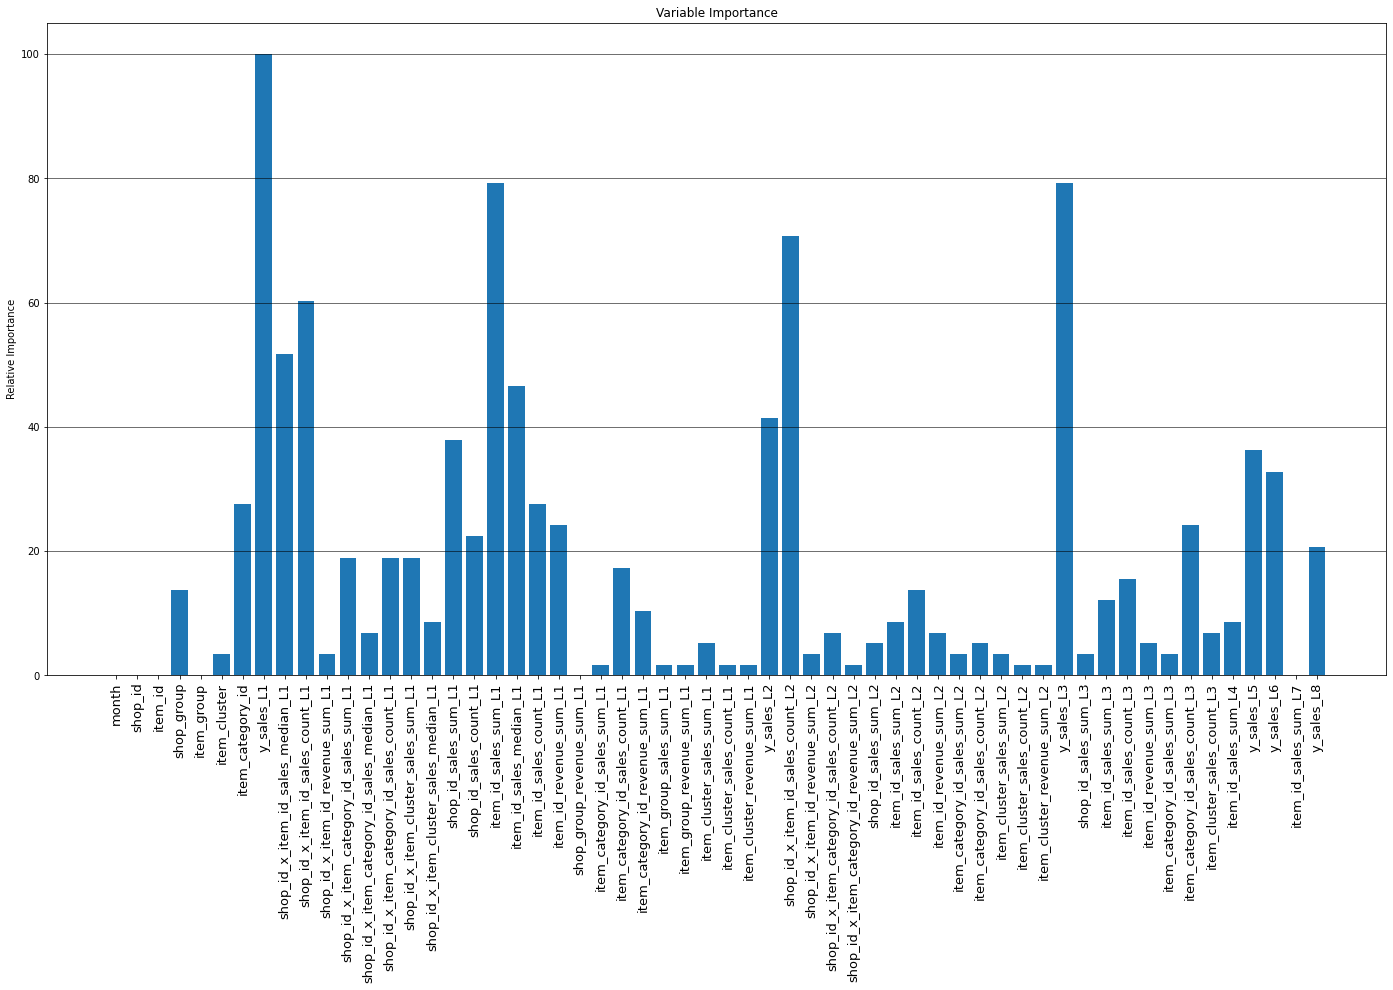

In [25]:
# Plot feature importance - Results Visualization
if par["MODEL_TYPE"] == 'LGBM':
    print_threshold = 25
    feature_importance = model_fit.feature_importances_
    fi = pd.DataFrame(zip(feature_names,feature_importance),columns=['feature','value'])
    fi = fi.sort_values('value',ascending=False,ignore_index=True)
    fi['norm_value'] = round(100*fi.value / fi.value.max(),2)
    fi['lag'] = fi.feature.apply(lambda x: (x.split('L')[-1]) if len(x.split('L'))> 1 else 0)
    fi['feature_base'] = fi.feature.apply(lambda x: x.split('_L')[0])
    print(fi.iloc[list(range(0,8))+list(range(-7,0)),:]) #[[1,3,5,7,-7,-5]][:])
    model_name_fi = par["MODEL_NAME"] + "_feature_importance.csv"
    fi.to_csv("./models_and_predictions/" + model_name_fi, index=False)
    # printout to assist with removing low-importance features for following runs
    if fi.norm_value.min() < print_threshold:
        fi_low = fi[fi.norm_value < print_threshold]
        fi_low = fi_low.sort_values(['lag','norm_value'])
        fi_low.norm_value = fi_low.norm_value.apply(lambda x: f'{round(x):d}')
        fi_low['lag_feature_importance'] = fi_low.apply(lambda x: f"{f'L{x.lag} fi{x.norm_value}':{len(x.feature_base)}s}",axis=1)
        print(fi_low.lag_feature_importance.to_list())
        print(fi_low.feature_base.to_list())
    # make importances relative to max importance
    feature_importance = 100.0 * (feature_importance / feature_importance.max())
    sorted_idx = np.arange(feature_importance.shape[0])
    pos = np.arange(sorted_idx.shape[0]) + .5
    plt.figure(figsize=(24,12)) 
    plt.bar(pos, feature_importance[sorted_idx], align='center')
    plt.xticks(pos, feature_names[sorted_idx])  # ensemble_feature_names[-1]
    plt.ylabel('Relative Importance')
    plt.title('Variable Importance')
    plt.tick_params(axis='x', which='major', labelsize = 13, labelrotation=90)
    plt.grid(True,which='major',axis='y')
    plt.tick_params(axis='y', which='major', grid_color='black',grid_alpha=0.7)
    # plt.savefig('LGBM_feature_importance_v1.4_mg.png')
    plt.show()

##**Document Results**

In [1]:
# Printout for copy-paste version control

print('\n------------------------------------------\n------------------------------------------')
print(f'{par["MODEL_NAME"]}  Model Type: {par["MODEL_TYPE"]}\nCoursera: \n------------------------------------------')
display_params()
print('------')
print(ensemble_scores)
print('------')
print(ensemble_scores.describe(percentiles=[], include=np.number))
print(f'------\nHighest and Lowest Feature Importance for Final Model:\n{fi.iloc[list(range(0,8))+list(range(-7,0)),:]}\n------')
print(y_submission.head(8))
print('------------------------------------------\n\n')



------------------------------------------
------------------------------------------


NameError: ignored

##**Stop Execution / Ensemble**

In [21]:
# Dummy cell to stop the execution so we don't run any of the random code below (if we select "Run All", e.g.)
b4 = b5

NameError: ignored

In [ ]:
'''

Best Coursera score so far: 8/10 public and private LB scores are: 0.985186 and 0.979359 on 5/12 with Andreas' numbers
Best with this model: v7_ens21 8/10 public and private LB scores are: 0.974590 and 0.971219

LGBMv10_15ens 8/10 public and private LB scores are: 0.984054 and 0.979126
* LGBMv10_13ens 8/10 public and private LB scores are: 0.976077 and 0.973442
* LGBMv10_11ens 8/10 public and private LB scores are: 0.977330 and 0.974200  same as v10_10ens, but removed all features with importance below 20%
*** LGBMv10_10ens 8/10 public and private LB scores are: 0.975422 and 0.971682
LGBMv10_09ens 8/10 public and private LB scores are: 0.984677 and 0.984238
LGBMv10_08ens 8/10 public and private LB scores are: 0.984238 and 0.982864
LGBMv10_07ens 8/10 public and private LB scores are: 0.985275 and 0.985093
LGBMv10_06ens 8/10 public and private LB scores are: 0.984912 and 0.983360
LGBMv10_v9_18noscaler 8/10 8/10 public and private LB scores are: 0.984643 and 0.985256
LGBMv10_v9_18 8/10 public and private LB scores are: 0.982740 and 0.983633  robust scaler used
LGBMv9_18ens 8/10 public and private LB scores are: 0.984137 and 0.984686
LGBMv9_09clip 8/10 public and private LB scores are: 0.984877 and 0.985790
LGBMv9_08clip 8/10 public and private LB scores are: 0.985158 and 0.986282
LGBMv9_04ens (less memory) 8/10 public and private LB scores are: 0.981707 and 0.985473
* LGBMv9_03ens 8/10 public and private LB scores are: 0.975438 and 0.973606
LGBMv8_v7_21B_ens 8/10 public and private LB scores are: 0.976147 and 0.972920
*** LGBMv6v7_bag06 8/10 public and private LB scores are: 0.974873 and 0.971385
* LGBMv6v7_bag05 8/10 public and private LB scores are: 0.975973 and 0.972537
**** v7_ens21 8/10 public and private LB scores are: 0.974590 and 0.971219
** v7_ens20 8/10 public and private LB scores are: 0.975499 and 0.971916
* v6_ens32 8/10 public and private LB scores are: 0.975826 and 0.972352
v6_10 8/10 public and private LB scores are: 0.984495 and 0.978631
v6_ens01 (avg v6 #17 through #31): 8/10 public and private LB scores are: 0.984457 and 0.978061
v6_ens33 8/10 public and private LB scores are: 0.980232 and 0.975554
v7_03 8/10 public and private LB scores are: 0.980832 and 0.975157
v7_ens07 8/10 public and private LB scores are: 0.980749 and 0.978082

------------------------------------------
------------------------------------------
LGBMv10_15ens  Model Type: LGBM
------------------------------------------
Coursera: 8/10 public and private LB scores are: 0.984054 and 0.979126
Wed 19:10:11 07/15/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  Size of X_train_np = 595.7 MB;  N Training Runs for this Model: 2
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales']
COLUMNS_TO_LAG[6] = ['y_sales']
COLUMNS_TO_LAG[7] = ['item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales']
CARTPROD_FILL_MONTH_BEGIN = 13; TRAIN_MONTH_START = [13]; TRAIN_FINAL_MONTH = [29]; N_VAL_MONTHS = [False]; USE_CARTESIAN_FILL = True; CART_PROD_INCLUDES_TEST = False; CARTPROD_FILLNA_WITH_0 = True
USE_ROBUST_SCALER = True; ROBUST_SCALER_QUANTILES = (20, 80); USE_MINMAX_SCALER = True; MINMAX_RANGE = (0, 32000); DATA_TYPE = <class 'numpy.int16'>
LEARNING_RATE = [0.02, 0.005]; MAX_ITERATIONS = [8000]; EARLY_STOPPING = [200]; REGULARIZATION = [0.4]; SEED_VALUES = [42]
------
     lr   reg  max_iter  estop  start  end  n_val_mo  seed  trR2  valR2  tr_rmse  val_rmse  best_iter  best_val_rmse model_time predict_time total_time
0 0.020 0.400      8000    200     13   29     False    42 0.572  0.427    0.743     0.783          0      1,253.473   00:35:36     00:13:33   00:49:09
1 0.005 0.400      8000    200     13   29     False    42 0.549  0.427    0.763     0.784          0      1,254.303   01:24:53     00:35:09   02:00:02
------
         lr   reg  max_iter  estop  start  end  seed  trR2  valR2  tr_rmse  val_rmse  best_iter  best_val_rmse
count     2     2         2      2      2    2     2     2      2        2         2          2              2
mean  0.013 0.400      8000    200     13   29    42 0.561  0.427    0.753     0.784          0      1,253.888
std   0.011     0         0      0      0    0     0 0.017  0.001    0.014     0.000          0          0.587
min   0.005 0.400      8000    200     13   29    42 0.549  0.427    0.743     0.783          0      1,253.473
50%   0.013 0.400      8000    200     13   29    42 0.561  0.427    0.753     0.784          0      1,253.888
max   0.020 0.400      8000    200     13   29    42 0.572  0.427    0.763     0.784          0      1,254.303
------
Highest and Lowest Feature Importance for Final Model:
                             feature  value  norm_value lag                   feature_base
0             item_id_sales_count_L1   9378         100   1            item_id_sales_count
1               item_id_sales_sum_L1   9199      98.090   1              item_id_sales_sum
2                       item_cluster   8256      88.040   0                   item_cluster
3                            item_id   7862      83.830   0                        item_id
4                   item_category_id   7540      80.400   0               item_category_id
5             item_id_revenue_sum_L1   7261      77.430   1            item_id_revenue_sum
6                            shop_id   6958      74.190   0                        shop_id
7                         y_sales_L1   6754      72.020   1                        y_sales
51       item_cluster_sales_count_L2   2536      27.040   2       item_cluster_sales_count
52              item_id_sales_sum_L3   2535      27.030   3              item_id_sales_sum
53  shop_id_x_item_id_sales_count_L2   2293      24.450   2  shop_id_x_item_id_sales_count
54   item_category_id_sales_count_L3   2170      23.140   3   item_category_id_sales_count
55       item_cluster_sales_count_L3   2067      22.040   3       item_cluster_sales_count
56   item_category_id_sales_count_L2   1987      21.190   2   item_category_id_sales_count
57     item_category_id_sales_sum_L3   1879      20.040   3     item_category_id_sales_sum
------
   ID  item_cnt_month
0   0           0.781
1   1           0.079
2   2           1.174
3   3           0.247
4   4           0.875
5   5           0.697
6   6           0.514
7   7           0.095
------------------------------------------
------------------------------------------
------------------------------------------

LGBMv10_14ens  Model Type: LGBM
------------------------------------------
Coursera: 8/10 public and private LB scores are: 1.003743 and 0.999306
Wed 16:11:56 07/15/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  Size of X_train_np = 595.7 MB;  N Training Runs for this Model: 1
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales']
COLUMNS_TO_LAG[6] = ['y_sales']
COLUMNS_TO_LAG[7] = ['item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales']
CARTPROD_FILL_MONTH_BEGIN = 13; TRAIN_MONTH_START = [13]; TRAIN_FINAL_MONTH = [29]; N_VAL_MONTHS = [False]; USE_CARTESIAN_FILL = True; CART_PROD_INCLUDES_TEST = False; CARTPROD_FILLNA_WITH_0 = True
USE_ROBUST_SCALER = True; ROBUST_SCALER_QUANTILES = (20, 80); USE_MINMAX_SCALER = True; MINMAX_RANGE = (0, 32000); DATA_TYPE = <class 'numpy.int16'>
LEARNING_RATE = [0.03]; MAX_ITERATIONS = [100]; EARLY_STOPPING = [100]; REGULARIZATION = [0.4]; SEED_VALUES = [42]
------
     lr   reg  max_iter  estop  start  end  n_val_mo  seed  trR2  valR2  tr_rmse  val_rmse  best_iter  best_val_rmse model_time predict_time total_time
0 0.030 0.400       100    100     13   29     False    42 0.443  0.393    0.847     0.807          0      1,290.627   00:01:52     00:00:17   00:02:10
------
         lr   reg  max_iter  estop  start  end  seed  trR2  valR2  tr_rmse  val_rmse  best_iter  best_val_rmse
count     1     1         1      1      1    1     1     1      1        1         1          1              1
mean  0.030 0.400       100    100     13   29    42 0.443  0.393    0.847     0.807          0      1,290.627
std     nan   nan       nan    nan    nan  nan   nan   nan    nan      nan       nan        nan            nan
min   0.030 0.400       100    100     13   29    42 0.443  0.393    0.847     0.807          0      1,290.627
50%   0.030 0.400       100    100     13   29    42 0.443  0.393    0.847     0.807          0      1,290.627
max   0.030 0.400       100    100     13   29    42 0.443  0.393    0.847     0.807          0      1,290.627
------
Highest and Lowest Feature Importance for Final Model:
                                      feature  value  norm_value lag                            feature_base
0                                  y_sales_L1    157         100   1                                 y_sales
1                        item_id_sales_sum_L1    151      96.180   1                       item_id_sales_sum
2                     item_id_sales_median_L1    141      89.810   1                    item_id_sales_median
3                            item_category_id    128      81.530   0                        item_category_id
4                      item_id_sales_count_L1    127      80.890   1                     item_id_sales_count
5                                  y_sales_L3    118      75.160   3                                 y_sales
6                                  y_sales_L5    109      69.430   5                                 y_sales
7            shop_id_x_item_id_sales_count_L1    104      66.240   1           shop_id_x_item_id_sales_count
51  shop_id_x_item_category_id_sales_count_L2     14       8.920   2  shop_id_x_item_category_id_sales_count
52                       item_id_sales_sum_L3     13       8.280   3                       item_id_sales_sum
53                item_cluster_sales_count_L3     13       8.280   3                item_cluster_sales_count
54           shop_id_x_item_id_revenue_sum_L2     12       7.640   2           shop_id_x_item_id_revenue_sum
55                item_cluster_revenue_sum_L2     11       7.010   2                item_cluster_revenue_sum
56                     item_id_revenue_sum_L3      7       4.460   3                     item_id_revenue_sum
57                item_cluster_sales_count_L2      5       3.180   2                item_cluster_sales_count
------
   ID  item_cnt_month
0   0           0.511
1   1           0.085
2   2           1.015
3   3           0.225
4   4           0.444
5   5           0.650
6   6           0.878
7   7           0.107

------------------------------------------
------------------------------------------
LGBMv10_13ens  Model Type: LGBM
------------------------------------------
Coursera: 8/10 public and private LB scores are: 0.976077 and 0.973442
Wed 15:31:20 07/15/20;  Size of df = 734.8 MB, Shape = (6226880, 59);  Size of X_train_np = 671.7 MB;  N Training Runs for this Model: 32
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales']
COLUMNS_TO_LAG[6] = ['y_sales']
COLUMNS_TO_LAG[7] = ['item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales']
CARTPROD_FILL_MONTH_BEGIN = 13; TRAIN_MONTH_START = [13]; TRAIN_FINAL_MONTH = [29, 32]; N_VAL_MONTHS = [False]; USE_CARTESIAN_FILL = True; CART_PROD_INCLUDES_TEST = False; CARTPROD_FILLNA_WITH_0 = True
USE_ROBUST_SCALER = True; ROBUST_SCALER_QUANTILES = (20, 80); USE_MINMAX_SCALER = True; MINMAX_RANGE = (0, 32000); DATA_TYPE = <class 'numpy.int16'>
LEARNING_RATE = [0.05, 0.03]; MAX_ITERATIONS = [4000]; EARLY_STOPPING = [100]; REGULARIZATION = [0.4, 0.1]; SEED_VALUES = [42, 43, 44, 45]
------
      lr   reg  max_iter  estop  start  end  n_val_mo  seed  trR2  valR2  tr_rmse  val_rmse      model_time    predict_time      total_time
0  0.050 0.400      4000    100     13   29     False    42 0.558  0.426    0.755     0.784 00:02:22.796827 00:00:14.489164 00:02:37.381230
1  0.050 0.400      4000    100     13   29     False    43 0.558  0.426    0.755     0.784 00:02:17.317521 00:00:14.820192 00:02:32.234120
2  0.050 0.400      4000    100     13   29     False    44 0.558  0.426    0.755     0.784 00:02:16.263556 00:00:15.967203 00:02:32.325884
3  0.050 0.400      4000    100     13   29     False    45 0.558  0.426    0.755     0.784 00:02:15.919261 00:00:16.058071 00:02:32.073075
4  0.050 0.400      4000    100     13   32     False    42 0.530  0.406    0.771     0.801 00:01:35.580222 00:00:07.445304 00:01:43.121361
5  0.050 0.400      4000    100     13   32     False    43 0.530  0.406    0.771     0.801 00:01:36.062911 00:00:07.566848 00:01:43.728209
6  0.050 0.400      4000    100     13   32     False    44 0.530  0.406    0.771     0.801 00:01:35.617126 00:00:07.505136 00:01:43.219945
7  0.050 0.400      4000    100     13   32     False    45 0.530  0.406    0.771     0.801 00:01:36.287204 00:00:07.578750 00:01:43.964531
8  0.050 0.100      4000    100     13   29     False    42 0.553  0.417    0.760     0.790 00:04:11.752687 00:00:37.579412 00:04:49.431376
9  0.050 0.100      4000    100     13   29     False    43 0.553  0.417    0.760     0.790 00:04:15.647176 00:00:37.730305 00:04:53.478163
10 0.050 0.100      4000    100     13   29     False    44 0.553  0.417    0.760     0.790 00:04:14.993836 00:00:38.232967 00:04:53.322473
11 0.050 0.100      4000    100     13   29     False    45 0.553  0.417    0.760     0.790 00:04:12.614834 00:00:38.111595 00:04:50.826675
12 0.050 0.100      4000    100     13   32     False    42 0.544  0.413    0.759     0.797 00:04:33.974918 00:00:38.127535 00:05:12.201225
13 0.050 0.100      4000    100     13   32     False    43 0.544  0.413    0.759     0.797 00:04:36.700797 00:00:37.756702 00:05:14.556847
14 0.050 0.100      4000    100     13   32     False    44 0.544  0.413    0.759     0.797 00:04:37.805054 00:00:38.317471 00:05:16.223452
15 0.050 0.100      4000    100     13   32     False    45 0.544  0.413    0.759     0.797 00:04:40.377308 00:00:39.191690 00:05:19.669424
16 0.030 0.400      4000    100     13   29     False    42 0.564  0.426    0.750     0.784 00:03:37.931630 00:00:30.874559 00:04:08.905109
17 0.030 0.400      4000    100     13   29     False    43 0.564  0.426    0.750     0.784 00:03:37.574522 00:00:31.429285 00:04:09.103564
18 0.030 0.400      4000    100     13   29     False    44 0.564  0.426    0.750     0.784 00:03:34.492661 00:00:31.136816 00:04:05.725260
19 0.030 0.400      4000    100     13   29     False    45 0.564  0.426    0.750     0.784 00:03:34.360388 00:00:31.442585 00:04:05.901330
20 0.030 0.400      4000    100     13   32     False    42 0.531  0.403    0.770     0.804 00:02:16.444590 00:00:15.645488 00:02:32.191298
21 0.030 0.400      4000    100     13   32     False    43 0.531  0.403    0.770     0.804 00:02:17.903275 00:00:15.714108 00:02:33.714707
22 0.030 0.400      4000    100     13   32     False    44 0.531  0.403    0.770     0.804 00:02:18.900813 00:00:16.256304 00:02:35.256094
23 0.030 0.400      4000    100     13   32     False    45 0.531  0.403    0.770     0.804 00:02:20.429069 00:00:16.108170 00:02:36.637124
24 0.030 0.100      4000    100     13   29     False    42 0.548  0.420    0.763     0.788 00:06:18.510325 00:00:57.076864 00:07:15.686213
25 0.030 0.100      4000    100     13   29     False    43 0.548  0.420    0.763     0.788 00:06:18.194431 00:00:58.029560 00:07:16.323680
26 0.030 0.100      4000    100     13   29     False    44 0.548  0.420    0.763     0.788 00:06:14.427514 00:00:57.702900 00:07:12.228839
27 0.030 0.100      4000    100     13   29     False    45 0.548  0.420    0.763     0.788 00:06:16.986484 00:00:58.380872 00:07:15.469333
28 0.030 0.100      4000    100     13   32     False    42 0.527  0.410    0.773     0.798 00:05:05.247308 00:00:43.026598 00:05:48.373926
29 0.030 0.100      4000    100     13   32     False    43 0.527  0.410    0.773     0.798 00:05:04.072583 00:00:42.961761 00:05:47.134938
30 0.030 0.100      4000    100     13   32     False    44 0.527  0.410    0.773     0.798 00:04:59.065499 00:00:43.050558 00:05:42.215707
31 0.030 0.100      4000    100     13   32     False    45 0.527  0.410    0.773     0.798 00:04:56.972108 00:00:42.970691 00:05:40.045130
------
         lr   reg  max_iter  estop  start    end   seed  trR2  valR2  tr_rmse  val_rmse              model_time            predict_time              total_time
count    32    32        32     32     32     32     32    32     32       32        32                      32                      32                      32
mean  0.040 0.250      4000    100     13 30.500 43.500 0.544  0.415    0.763     0.793  0 days 00:03:44.725763  0 days 00:00:30.883920  0 days 00:04:15.708445
std   0.010 0.152         0      0      0  1.524  1.136 0.013  0.008    0.008     0.007  0 days 00:01:31.107823  0 days 00:00:16.019000  0 days 00:01:47.075789
min   0.030 0.100      4000    100     13     29     42 0.527  0.403    0.750     0.784  0 days 00:01:35.580222  0 days 00:00:07.445304  0 days 00:01:43.121361
50%   0.040 0.250      4000    100     13 30.500 43.500 0.546  0.415    0.761     0.794  0 days 00:03:54.842158  0 days 00:00:34.510998  0 days 00:04:29.267470
max   0.050 0.400      4000    100     13     32     45 0.564  0.426    0.773     0.804  0 days 00:06:18.510325  0 days 00:00:58.380872  0 days 00:07:16.323680
------
Highest and Lowest Feature Importance for Final Model:
                             feature  value  norm_value lag                   feature_base
0             item_id_revenue_sum_L1   1936         100   1            item_id_revenue_sum
1                       item_cluster   1905      98.400   0                   item_cluster
2             item_id_sales_count_L1   1872      96.690   1            item_id_sales_count
3          item_cluster_sales_sum_L1   1863      96.230   1         item_cluster_sales_sum
4                   item_category_id   1783      92.100   0               item_category_id
5                            shop_id   1783      92.100   0                        shop_id
6                            item_id   1716      88.640   0                        item_id
7               item_id_sales_sum_L1   1714      88.530   1              item_id_sales_sum
51              shop_id_sales_sum_L3    954      49.280   3              shop_id_sales_sum
52  shop_id_x_item_id_sales_count_L2    930      48.040   2  shop_id_x_item_id_sales_count
53                        y_sales_L5    921      47.570   5                        y_sales
54                        y_sales_L6    869      44.890   6                        y_sales
55              shop_id_sales_sum_L2    841      43.440   2              shop_id_sales_sum
56                        y_sales_L8    760      39.260   8                        y_sales
57                        shop_group    689      35.590   0                     shop_group
------
   ID  item_cnt_month
0   0           0.913
1   1           0.079
2   2           1.124
3   3           0.226
4   4           1.030
5   5           0.689
6   6           0.400
7   7           0.090
------
15 of 32: LR = 0.05; LFF = 0.1, train_start = 13; train_end = 32; seed = 44
[2339]	valid_0's rmse: 1275.27
model LGBM fit time: 0:04:37
Transform and Predict train/val/test time: 0:00:38
R^2 train =  0.5440    R^2 val =  0.4127
RMSE train = 0.7594    RMSE val = 0.7968
Total Iteration Execution Time = 0:05:18
------
16 of 32: LR = 0.05; LFF = 0.1, train_start = 13; train_end = 32; seed = 45
[2339]	valid_0's rmse: 1275.27
model LGBM fit time: 0:04:40
Transform and Predict train/val/test time: 0:00:39
R^2 train =  0.5440    R^2 val =  0.4127
RMSE train = 0.7594    RMSE val = 0.7968
Total Iteration Execution Time = 0:05:22
------
17 of 32: LR = 0.03; LFF = 0.4, train_start = 13; train_end = 29; seed = 42
[1893]	valid_0's rmse: 1255.04
model LGBM fit time: 0:03:38
Transform and Predict train/val/test time: 0:00:30
R^2 train =  0.5635    R^2 val =  0.4260
RMSE train = 0.7503    RMSE val = 0.7843
Total Iteration Execution Time = 0:04:11
------
20 of 32: LR = 0.03; LFF = 0.4, train_start = 13; train_end = 29; seed = 45
[1893]	valid_0's rmse: 1255.04
model LGBM fit time: 0:03:34
Transform and Predict train/val/test time: 0:00:31
R^2 train =  0.5635    R^2 val =  0.4260
RMSE train = 0.7503    RMSE val = 0.7843
Total Iteration Execution Time = 0:04:08
------------------------------------------
------------------------------------------
------------------------------------------


------------------------------------------
------------------------------------------
LGBMv10_11ens  model_type: LGBM
same as v10_10ens, but removed all features with importance below 20%
------------------------------------------
Coursera: 8/10 public and private LB scores are: 0.977330 and 0.974200
Wed 12:48:03 07/15/20;  Size of df = 635.1 MB, Shape = (6226880, 51);  Size of X_train_np = 579.1 MB;  N Training Runs for this Model: 4
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight; Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS = OrderedDict([('sales', ['sum', 'median', 'count']), ('revenue', ['sum'])]); SALES_TRAIN_CLIP_L = 0; SALES_TRAIN_CLIP_H = 20; SALES_PREDICT_CLIP_L = 0; SALES_PREDICT_CLIP_H = 20
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'item_id_revenue_sum', 'item_category_id_sales_count']
COLUMNS_TO_LAG[4] = ['item_id_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales']
COLUMNS_TO_LAG[6] = ['y_sales']
COLUMNS_TO_LAG[7] = ['item_id_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales']
CARTPROD_FILL_MONTH_BEGIN = 13; TRAIN_MONTH_START = [13]; TRAIN_FINAL_MONTH = [29, 32]; N_VAL_MONTHS = [False]; USE_CARTESIAN_FILL = True; CART_PROD_INCLUDES_TEST = False; CARTPROD_FILLNA_WITH_0 = True
USE_ROBUST_SCALER = True; ROBUST_SCALER_QUANTILES = (20, 80); USE_MINMAX_SCALER = True; MINMAX_RANGE = (0, 32000); DATA_TYPE = <class 'numpy.int16'>
LEARNING_RATE = [0.05]; MAX_ITERATIONS = [4000]; EARLY_STOPPING = [100]; REGULARIZATION = [0.4]; SEED_VALUES = [42, 43]
------
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.400     13   29    42 0.582  0.433    0.734     0.779
1 0.050 0.400     13   29    43 0.568  0.425    0.746     0.785
2 0.050 0.400     13   32    42 0.521  0.399    0.778     0.806
3 0.050 0.400     13   32    43 0.531  0.411    0.770     0.798
------
         lr    ff  start    end   seed  trR2  valR2  tr_rmse  val_rmse
count     4     4      4      4      4     4      4        4         4
mean  0.050 0.400     13 30.500 42.500 0.550  0.417    0.757     0.792
std       0     0      0  1.732  0.577 0.029  0.015    0.020     0.012
min   0.050 0.400     13     29     42 0.521  0.399    0.734     0.779
50%   0.050 0.400     13 30.500 42.500 0.549  0.418    0.758     0.792
max   0.050 0.400     13     32     43 0.582  0.433    0.778     0.806
------
CPU 2 of 4: LR = 0.05; LFF = 0.4, train_start = 13; train_end = 29; seed = 43
[1300]	valid_0's rmse: 1256.21
model_lgbm fit in 0:12:45.955235
Predict and MinMax and Robust scalers inverse transforms done in 0:04:26.703348
R^2 train =  0.5681    R^2 val =  0.4249
RMSE train = 0.7463    RMSE val = 0.7851
TTSplit Execution Time = 0:00:03.526503
Model fit/predict Execution Time = 0:17:12.767771
Submission Execution Time = 0:00:00.659729
Total Iteration Execution Time = 0:17:16.954003
------
CPU 4 of 4: LR = 0.05; LFF = 0.4, train_start = 13; train_end = 32; seed = 43
[633]	valid_0's rmse: 1276.79
model_lgbm fit in 0:08:20.095208
Predict and MinMax and Robust scalers inverse transforms done in 0:01:35.307487
R^2 train =  0.5309    R^2 val =  0.4109
RMSE train = 0.7703    RMSE val = 0.7980
TTSplit Execution Time = 0:00:01.556474
Model fit/predict Execution Time = 0:09:55.510320
Total Iteration Execution Time = 0:09:57.782245
------
Highest and Lowest Feature Importance for Final Model:
                            feature  value  norm_value lag                  feature_base
0            item_id_sales_count_L1    824         100   1           item_id_sales_count
1              item_id_sales_sum_L1    823      99.880   1             item_id_sales_sum
2                           item_id    656      79.610   0                       item_id
3                      item_cluster    647      78.520   0                  item_cluster
4                  item_category_id    622      75.490   0              item_category_id
5            item_id_revenue_sum_L1    598      72.570   1           item_id_revenue_sum
6                           shop_id    581      70.510   0                       shop_id
7                             month    574      69.660   0                         month
43  item_category_id_sales_count_L3    234      28.400   3  item_category_id_sales_count
44        item_cluster_sales_sum_L2    231      28.030   2        item_cluster_sales_sum
45                       y_sales_L6    216      26.210   6                       y_sales
46        shop_group_revenue_sum_L1    214      25.970   1        shop_group_revenue_sum
47                       y_sales_L8    206          25   8                       y_sales
48      item_cluster_sales_count_L2    202      24.510   2      item_cluster_sales_count
49  item_category_id_sales_count_L2    175      21.240   2  item_category_id_sales_count
------
   ID  item_cnt_month
0   0           0.835
1   1           0.078
2   2           1.202
3   3           0.209
4   4           0.916
5   5           0.703
6   6           0.573
7   7           0.095
------------------------------------------
------------------------------------------
------------------------------------------

LGBMv10_10ens   Wed 06:42:21 07/15/20;  Size of df = 1008.8 MB, Shape = (6226880, 81);  Size of X_train_np = 926.5 MB;  N Training Runs for this Model: 4
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], ['shop_id', 'item_cluster'], 'shop_id', 'item_id', 'shop_group', 'item_category_id', 'item_group', 'item_cluster']
STATISTICS['sales'] = ['sum', 'median', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 7, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_median', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_median', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_median', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_median', 'item_id_sales_count', 'item_id_revenue_sum', 'shop_group_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_group_sales_sum', 'item_group_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_x_item_cluster_sales_sum', 'shop_id_x_item_cluster_sales_count', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_group_sales_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum', 'item_cluster_sales_count']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[7] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTPROD_FILL_MONTH_BEGIN = 13,  TRAIN_MONTH_START = [13],  TRAIN_MONTH_END = [29, 32], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.05], LGBM_MAX_ITERATIONS = 4000, LGBM_EARLY_STOPPING = 100, LGBM_FEATURE_FRACTION = [0.4], SEED_VALUES = [42, 43]
USE_ROBUST_SCALER = True, ROBUST_SCALER_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CARTPROD_FILLNA_WITH_0 = True
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.050 0.400     13   29    42 0.568  0.430    0.747     0.781
1 0.050 0.400     13   29    43 0.582  0.428    0.734     0.783
2 0.050 0.400     13   32    42 0.521  0.401    0.778     0.805
3 0.050 0.400     13   32    43 0.513  0.407    0.785     0.801
         lr    ff  start    end   seed  trR2  valR2  tr_rmse  val_rmse
count     4     4      4      4      4     4      4        4         4
mean  0.050 0.400     13 30.500 42.500 0.546  0.416    0.761     0.793
std       0     0      0  1.732  0.577 0.034  0.015    0.025     0.012
min   0.050 0.400     13     29     42 0.513  0.401    0.734     0.781
25%   0.050 0.400     13     29     42 0.519  0.405    0.744     0.783
50%   0.050 0.400     13 30.500 42.500 0.544  0.417    0.763     0.792
75%   0.050 0.400     13     32     43 0.571  0.428    0.780     0.802
max   0.050 0.400     13     32     43 0.582  0.430    0.785     0.805
   ID  item_cnt_month
0   0           0.740
1   1           0.076
2   2           1.193
3   3           0.240
4   4           0.978
5   5           0.711
6   6           0.495
7   7           0.105
Coursera: 8/10 public and private LB scores are: 0.975422 and 0.971682
4 of 4: LR = 0.05; LFF = 0.4, train_start = 13; train_end = 32; seed = 43
Early stopping, best iteration is:
[418]	valid_0's rmse: 1281.43
model_lgbm fit in 0:09:00.514980
Predict and MinMax and Robust scalers inverse transforms done in 0:01:01.297574
sklearn metrics r2 done in 0:00:00.064039
np and sklearn metrics rmse done in 0:00:00.038124
R^2 train =  0.5126    R^2 val =  0.4067
RMSE train = 0.7851    RMSE val = 0.8008
TTSplit Execution Time = 0:00:02.396470
Model fit/predict Execution Time = 0:10:01.918102
Submission Execution Time = 0:00:00.717338
Total Iteration Execution Time = 0:10:05.031910


LGBMv10_09ens   Tue 23:12:32 07/14/20;  Size of df = 722.3 MB, Shape = (6226880, 58);  Size of X_train_np = 585.4 MB;  N Training Runs for this Model: 3
STT_COLUMN_ORDER = ['month', 'sales', 'revenue', 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATS_FEATURES = [['shop_id', 'item_id'], ['shop_id', 'item_category_id'], 'shop_id', 'item_id', 'item_category_id', 'item_cluster']
STATISTICS['sales'] = ['sum', 'count'],  STATISTICS['revenue'] = ['sum'];  SALES_TRAIN_CLIP_L = 0, SALES_PREDICT_CLIP_L = 0
SHOPS_TO_DELETE = [9, 20]; ITEM_CATS_TO_DELETE = [8, 10, 32, 59, 80, 81, 82]; SCALE_MONTH = week_retail_weight
Lags(months) = [1, 2, 3, 4, 5, 6, 8]
COLUMNS_TO_LAG[1] = ['y_sales', 'shop_id_x_item_id_sales_count', 'shop_id_x_item_id_revenue_sum', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'shop_id_sales_count', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_category_id_revenue_sum', 'item_cluster_sales_sum', 'item_cluster_sales_count', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[2] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_x_item_category_id_sales_count', 'shop_id_x_item_category_id_revenue_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_id_revenue_sum', 'item_category_id_sales_sum', 'item_cluster_sales_sum', 'item_cluster_revenue_sum']
COLUMNS_TO_LAG[3] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'shop_id_sales_sum', 'item_id_sales_sum', 'item_id_sales_count', 'item_category_id_sales_sum', 'item_category_id_sales_count', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[4] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[5] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[6] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
COLUMNS_TO_LAG[8] = ['y_sales', 'shop_id_x_item_category_id_sales_sum', 'item_id_sales_sum', 'item_cluster_sales_sum']
CARTPROD_FILL_MONTH_BEGIN = 13,  TRAIN_MONTH_START = [13],  TRAIN_MONTH_END = [29], N_VAL_MONTHS = False
LGBM_LEARNING_RATE = [0.008], LGBM_MAX_ITERATIONS = 10000, LGBM_EARLY_STOPPING = 200, LGBM_FEATURE_FRACTION = [0.3], SEED_VALUES = [42, 43, 44]
USE_ROBUST_SCALER = True, ROBUST_SCALER_QUANTILES = (20, 80), USE_MINMAX_SCALER = True, MINMAX_RANGE = (0, 32000), DATA_TYPE = <class 'numpy.int16'>
USE_CARTESIAN_FILL = True, CART_PROD_INCLUDES_TEST = False, CARTPROD_FILLNA_WITH_0 = True
     lr    ff  start  end  seed  trR2  valR2  tr_rmse  val_rmse
0 0.008 0.300     13   29    42 0.556  0.426    0.756     0.784
1 0.008 0.300     13   29    43 0.559  0.424    0.754     0.786
2 0.008 0.300     13   29    44 0.560  0.427    0.753     0.784
         lr    ff  start  end   seed  trR2  valR2  tr_rmse  val_rmse
count     3     3      3    3      3     3      3        3         3
mean  0.008 0.300     13   29     43 0.558  0.426    0.755     0.785
std       0     0      0    0      1 0.002  0.002    0.002     0.001
min   0.008 0.300     13   29     42 0.556  0.424    0.753     0.784
25%   0.008 0.300     13   29 42.500 0.558  0.425    0.754     0.784
50%   0.008 0.300     13   29     43 0.559  0.426    0.754     0.784
75%   0.008 0.300     13   29 43.500 0.559  0.427    0.755     0.785
max   0.008 0.300     13   29     44 0.560  0.427    0.756     0.786
   ID  item_cnt_month
0   0           0.833
1   1           0.082
2   2           1.153
3   3           0.224
4   4           1.138
5   5           0.665
6   6           0.466
7   7           0.124
Coursera: 8/10 public and private LB scores are: 0.984677 and 0.984238
1 of 3: LR = 0.008; LFF = 0.3, train_start = 13; train_end = 29; seed = 42
[7621]	valid_0's rmse: 1254.57
Early stopping, best iteration is:
[7421]	valid_0's rmse: 1254.56
model_lgbm fit in 1:12:32.058546
Predict and MinMax and Robust scalers inverse transforms done in 0:33:24.823812
sklearn metrics r2 done in 0:00:00.162204
np and sklearn metrics rmse done in 0:00:00.041076
R^2 train =  0.5564    R^2 val =  0.4264
RMSE train = 0.7563    RMSE val = 0.7840
TTSplit Execution Time = 0:00:01.403296
Model fit/predict Execution Time = 1:45:57.087654
Submission Execution Time = 0:00:00.789723
Total Iteration Execution Time = 1:45:59.280673
3 of 3: LR = 0.008; LFF = 0.3, train_start = 13; train_end = 29; seed = 44
Early stopping, best iteration is:
[7572]	valid_0's rmse: 1254.12
model_lgbm fit in 1:14:11.946720
Predict and MinMax and Robust scalers inverse transforms done in 0:36:43.612870
sklearn metrics r2 done in 0:00:00.059011
np and sklearn metrics rmse done in 0:00:00.035089
R^2 train =  0.5603    R^2 val =  0.4268
RMSE train = 0.7531    RMSE val = 0.7838
TTSplit Execution Time = 0:00:05.081258
Model fit/predict Execution Time = 1:50:55.684636
Submission Execution Time = 0:00:00.736886
Total Iteration Execution Time = 1:51:01.502780

'''
nocode=True

##**Averaging Several Stored Prediction/Submission Files**

In [ ]:
# average several submission files to get ensemble average
%cd "{GDRIVE_REPO_PATH}"
# source_dir = Path('models_and_predictions/bagging_LGBM')
# prediction_files = source_dir.iterdir()
source_dir = 'models_and_predictions/bagging_LGBM'
prediction_files = os.listdir(source_dir)
print("Loading Files from Google Drive repo into Colab...\n")

# filename to save ensemble average predictions for submission
ensemble_name = 'LGBMv6v7_bag06'

print(f'filename {ensemble_name}')
# Loop to load the data files into appropriately-named pandas DataFrames, and save in np array for easy calc of ensemble average
preds = []
for f_name in prediction_files:
    filename = f_name.rsplit("/")[-1]
    data_frame_name = filename.split(".")[0][:-11]
    path_name = os.path.join('models_and_predictions/bagging_LGBM/'+ filename)
    exec(data_frame_name + " = pd.read_csv(path_name)")
    print(f'Data Frame: {data_frame_name}; n_rows = {len(eval(data_frame_name))}, n_cols = ')
    preds.append(eval(data_frame_name).item_cnt_month.to_numpy())

# Simple ensemble averaging
pred_ens_avg = np.mean(preds, axis=0)
ensemble_submission = LGBMv6mg_17_.copy(deep=True)
ensemble_submission.item_cnt_month = pred_ens_avg

ensemble_submission.to_csv("./models_and_predictions/" + ensemble_name + '_submission.csv', index=False)

display(ensemble_submission.head(8))
print(f'filename {ensemble_name} saved: {strftime("%a %X %x")}')
print('Coursera:  ')